# Path Finder: What are the potential paths between two nodes?
## This pipeline can be used to get a ranked path between A and B given a set of paths.


Example questions: 

What drugs may treat ovarian cancer (MONDO:0008170) patients with BRCA1 mutation?  

What is the mechanism of Olaparib being effective for patients with BRCA1 mutation?



In [34]:
# include path ../src in order to import modules
import sys
sys.path.append('../src')
import TCT as TCT
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [35]:
# Step1: List all the APIs in the translator system
APInames = TCT.list_Translator_APIs()
print(len(APInames))
print(APInames.keys())

98
dict_keys(['Automat-ctd(Trapi v1.4.0)', 'Automat-sri-reference-kg(Trapi v1.4.0)', 'Autonomous Relay System (ARS) TRAPI', 'BioLink API', 'BioThings AGR API', 'BioThings BioPlanet Pathway-Gene API', 'BioThings DDInter API', 'BioThings Explorer (BTE) TRAPI', 'BioThings FooDB API', 'BioThings FoodData Central API', 'BioThings GO Biological Process API', 'BioThings InnateDB API', 'BioThings RARe-SOURCE API', 'BioThings repoDB API', 'Biolink Lookup', 'Biothings Therapeutic Target Database API', 'COHD TRAPI', 'Complex Portal Web Service', 'Curated Query Service', 'EBI Proteins API', 'Gene-List Network Enrichment Analysis', 'Knowledge Collaboratory API', 'LitVar API', 'RaMP API v1.0.1', 'SmartAPI API', 'Sri-answer-appraiser(Trapi v1.4.0)', 'Sri-name-resolver', 'Sri-node-normalizer(Trapi v1.3.0)', 'Sri-node-normalizer(Trapi v1.4.0)', 'Translator Annotation Service', 'Workflow-runner(Trapi v1.4.0)', 'imProving Agent for TRAPI 1.4', 'Aragorn(Trapi v1.4.0)', 'ARAX Translator Reasoner - TRAPI 1.

In [17]:
# Step 2: Get metaKG and all predicates from Translator APIs
metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs
#print(metaKG.columns)
#print(metaKG.shape)

metaKG.to_csv('../metaData/metaKG.csv', index=False)
metaKG = pd.read_csv('../metaData/metaKG.csv')
All_predicates = list(set(metaKG['KG_category']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))

In [36]:
# Step 3: set input parameters

# Node1 for query
input_node1 = 'BRCA2'
input_node1_id = TCT.get_curie(input_node1)
print(input_node1_id)
input_node1_list = [input_node1_id]
input_node1_category = ['biolink:Gene'] # Node: this has to be in a format of biolink:xxx

#Node2 for query
input_node2_list = []
input_node2_category = ['biolink:Drug','biolink:SmallMolecule'] # Node: this has to be in a format of biolink:xxx
#input_node2_category = ['biolink:Gene','biolink:Protein']

# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,obj_list=input_node2_category,metaKG=metaKG)))
print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs_1 = TCT.select_API(sub_list=input_node1_category,obj_list=input_node2_category,metaKG=metaKG)
sele_APIs_1 = ['Automat-cam-kp(Trapi v1.4.0)']
print("all relevant APIs in Translator:")
print(sele_APIs_1)

# get API URLs
API_URLs_1 = TCT.get_Translator_API_URL(sele_APIs_1, APInames)

#-----------------#

# Node3 for query
input_node3 = 'ovarian cancer'
input_node3 = 'Olaparib'
input_node3_id = TCT.get_curie(input_node3)
input_node3_id = "MONDO:0008170"
print(input_node3_id)
#input_node1_id= "MONDO:0008170"
input_node3_list = [input_node3_id]
#input_node3_category = ['biolink:SmallMolecule', 'biolink:Drug','biolink:ChemicalSubstance'] # Node: this has to be in a format of biolink:xxx
input_node3_category = ['biolink:Disease'] # Node: this has to be in a format of biolink:xxx


# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates_2 = list(set(TCT.select_concept(sub_list=input_node3_category,obj_list=input_node2_category,metaKG=metaKG)))
print("all relevant predicates in Translator:")
print(sele_predicates_2)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs_2 = TCT.select_API(sub_list=input_node3_category,obj_list=input_node2_category,metaKG=metaKG)
print("all relevant APIs in Translator:")
print(sele_APIs_2)

# get API URLs
API_URLs_2 = TCT.get_Translator_API_URL(sele_APIs_2, 
                                      APInames)

NCBIGene:675
all relevant predicates in Translator:
['biolink:affects_response_to', 'biolink:negatively_correlated_with', 'biolink:sensitivity_associated_with', 'biolink:directly_physically_interacts_with', 'biolink:affected_by', 'biolink:affects', 'biolink:has_substrate', 'biolink:derives_into', 'biolink:has_part', 'biolink:associated_with_sensitivity_to', 'biolink:derives_from', 'biolink:causes', 'biolink:is_substrate_of', 'biolink:physically_interacts_with', 'biolink:decreases_response_to', 'biolink:disrupted_by', 'biolink:resistance_associated_with', 'biolink:binds', 'biolink:regulates', 'biolink:related_to', 'biolink:associated_with_resistance_to', 'biolink:correlated_with', 'biolink:part_of', 'biolink:increases_response_to', 'biolink:has_gene_product', 'biolink:positively_correlated_with', 'biolink:genetically_associated_with', 'biolink:disrupts', 'biolink:occurs_together_in_literature_with', 'biolink:genetic_association', 'biolink:response_affected_by', 'biolink:interacts_with',

In [21]:
input_node3_id

'MONDO:0008170'

In [37]:
# Step 4: Format query json
query_json = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node1_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of predicates
# Step 5: Query Translator APIs and parse results
result = TCT.parallel_api_query(API_URLs_1,query_json=query_json, max_workers=len(API_URLs_1))
# Step 6: Parse results
result_parsed = TCT.parse_KG(result)
# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:672"


Success!https://automat.ci.transltr.io/cam-kp/1.4/query?limit=100


In [39]:
result_parsed

{'PUBCHEM.COMPOUND:4477_NCBIGene:675': {'predicate': ['biolink:affects',
   'biolink:causes'],
  'subject': 'PUBCHEM.COMPOUND:4477',
  'object': 'NCBIGene:675',
  'primary_knowledge_source': ['infores:ctd', 'infores:ctd'],
  'aggregator_knowledge_source': ['infores:automat-cam-kp',
   'infores:automat-cam-kp'],
  'evidence': ['PUBCHEM.COMPOUND:4477_biolink:affects_NCBIGene:675_infores:automat-cam-kp_infores:automat-cam-kp',
   'PUBCHEM.COMPOUND:4477_biolink:causes_NCBIGene:675_infores:ctd_infores:automat-cam-kp']},
 'PUBCHEM.COMPOUND:5743_NCBIGene:675': {'predicate': ['biolink:causes',
   'biolink:affects'],
  'subject': 'PUBCHEM.COMPOUND:5743',
  'object': 'NCBIGene:675',
  'primary_knowledge_source': ['infores:ctd', 'infores:ctd'],
  'aggregator_knowledge_source': ['infores:automat-cam-kp',
   'infores:automat-cam-kp'],
  'evidence': ['PUBCHEM.COMPOUND:5743_biolink:causes_NCBIGene:675_infores:automat-cam-kp_infores:automat-cam-kp',
   'PUBCHEM.COMPOUND:5743_biolink:affects_NCBIGene:6

<AxesSubplot:title={'center':'Ranking of one-hop nodes by predicate'}, ylabel='Predicate'>

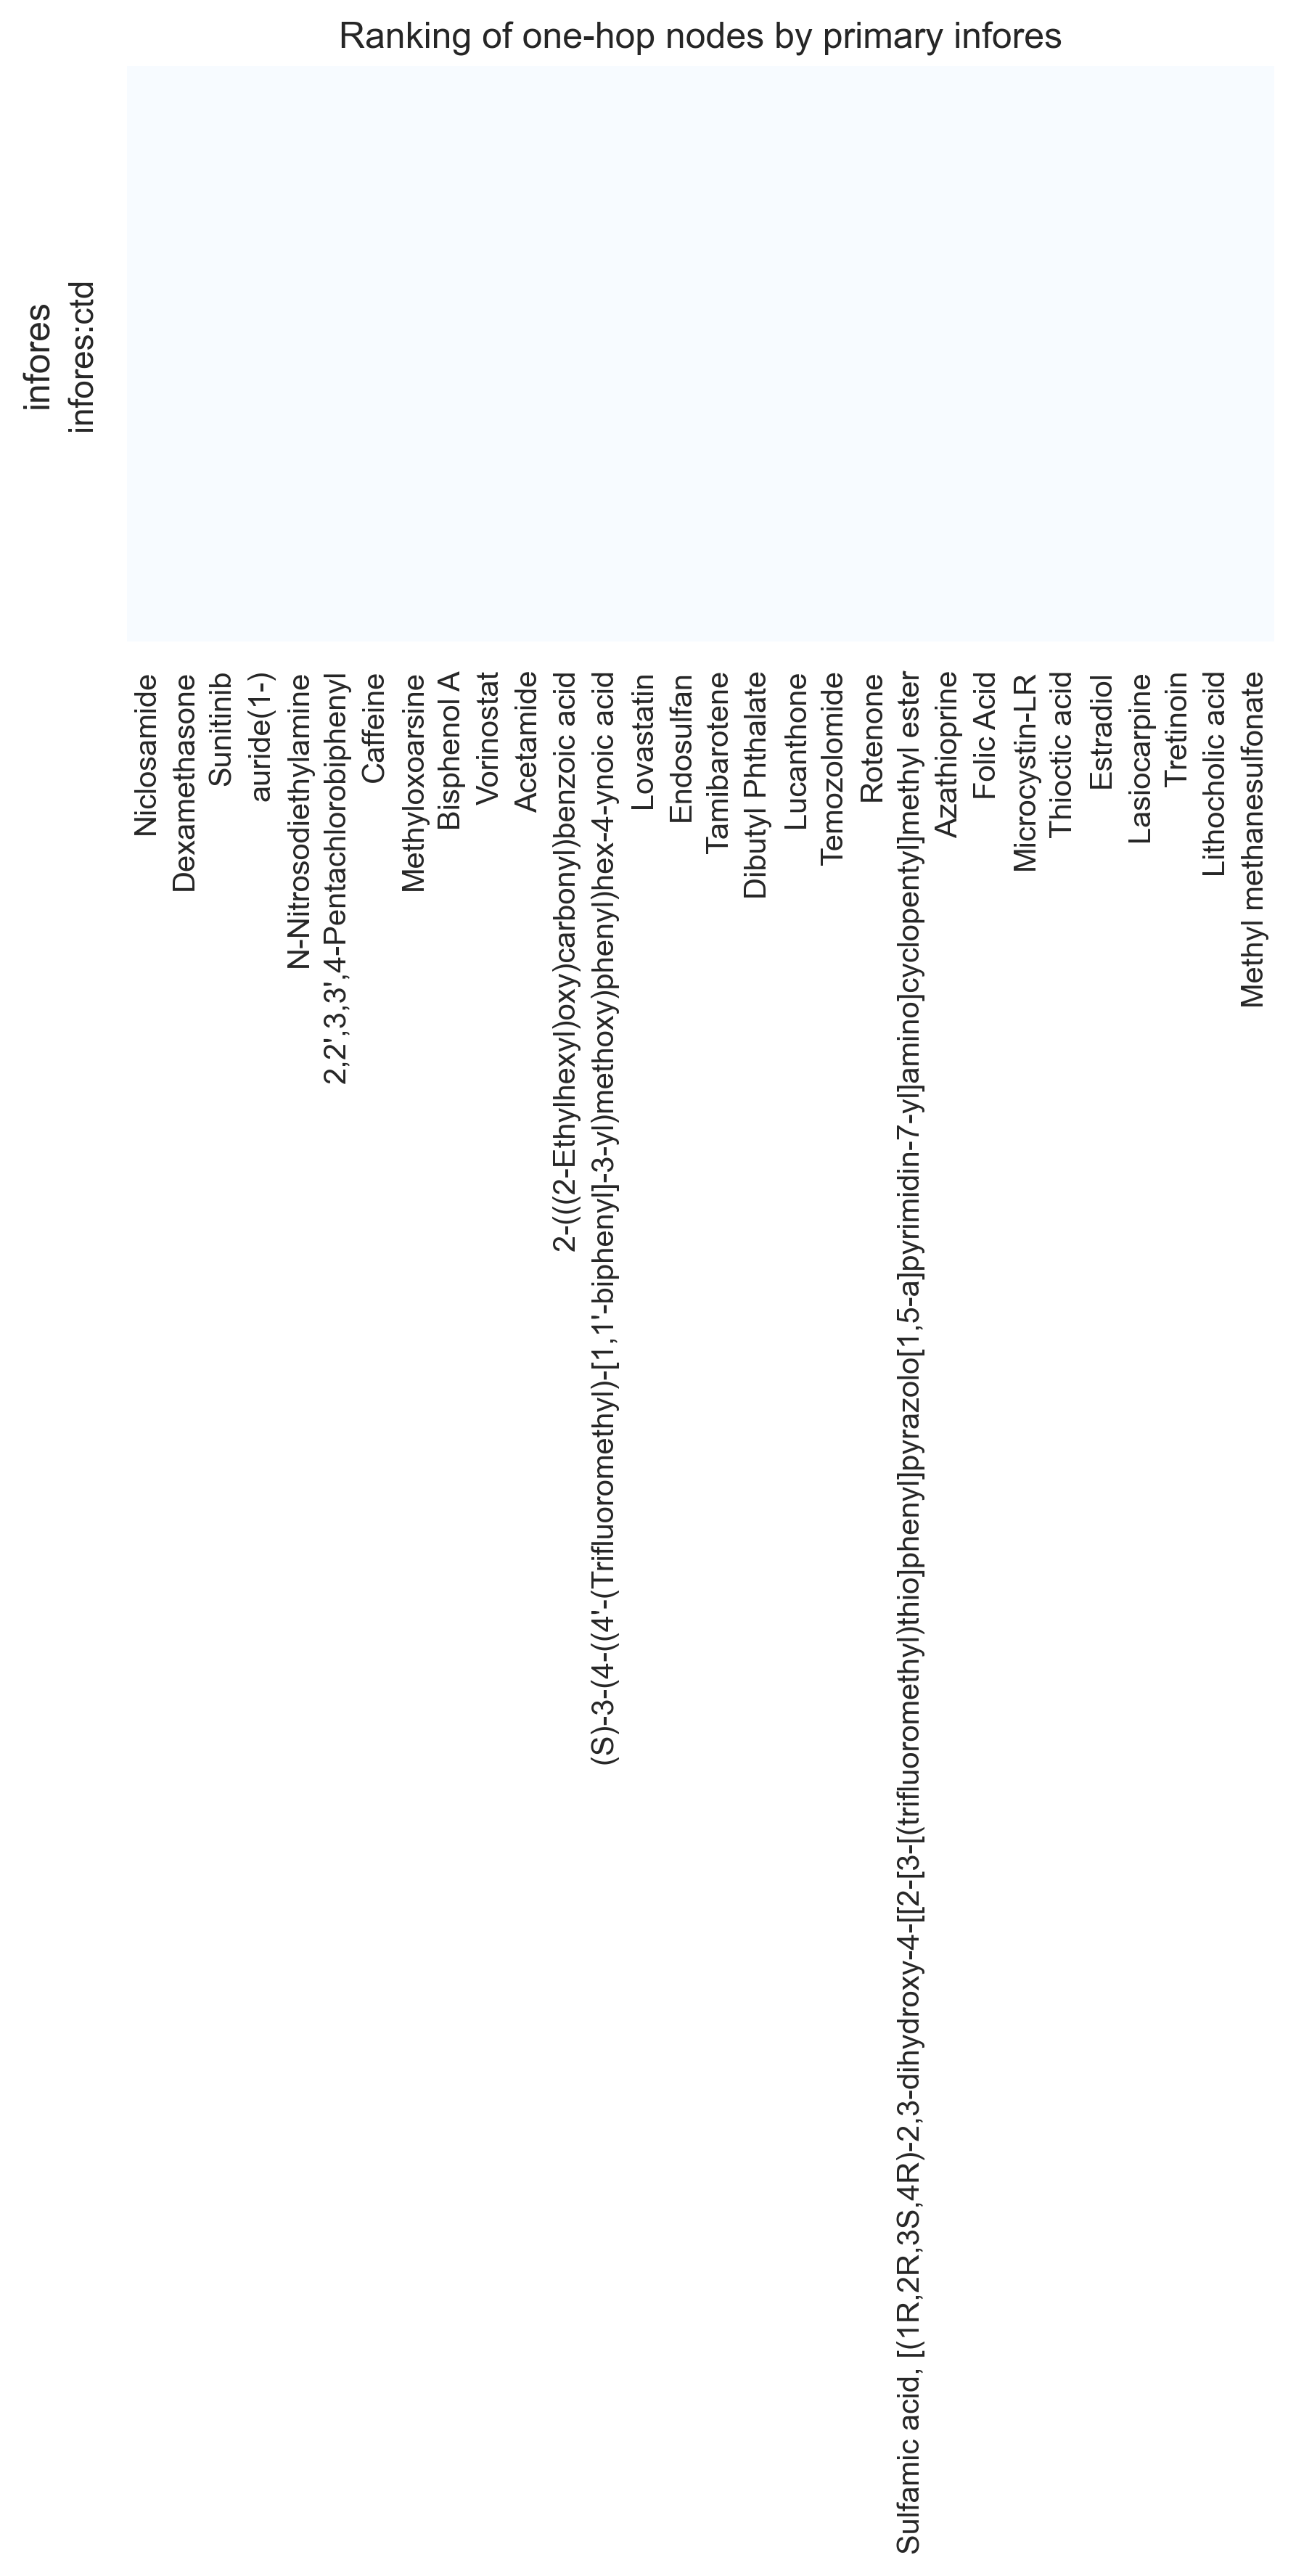

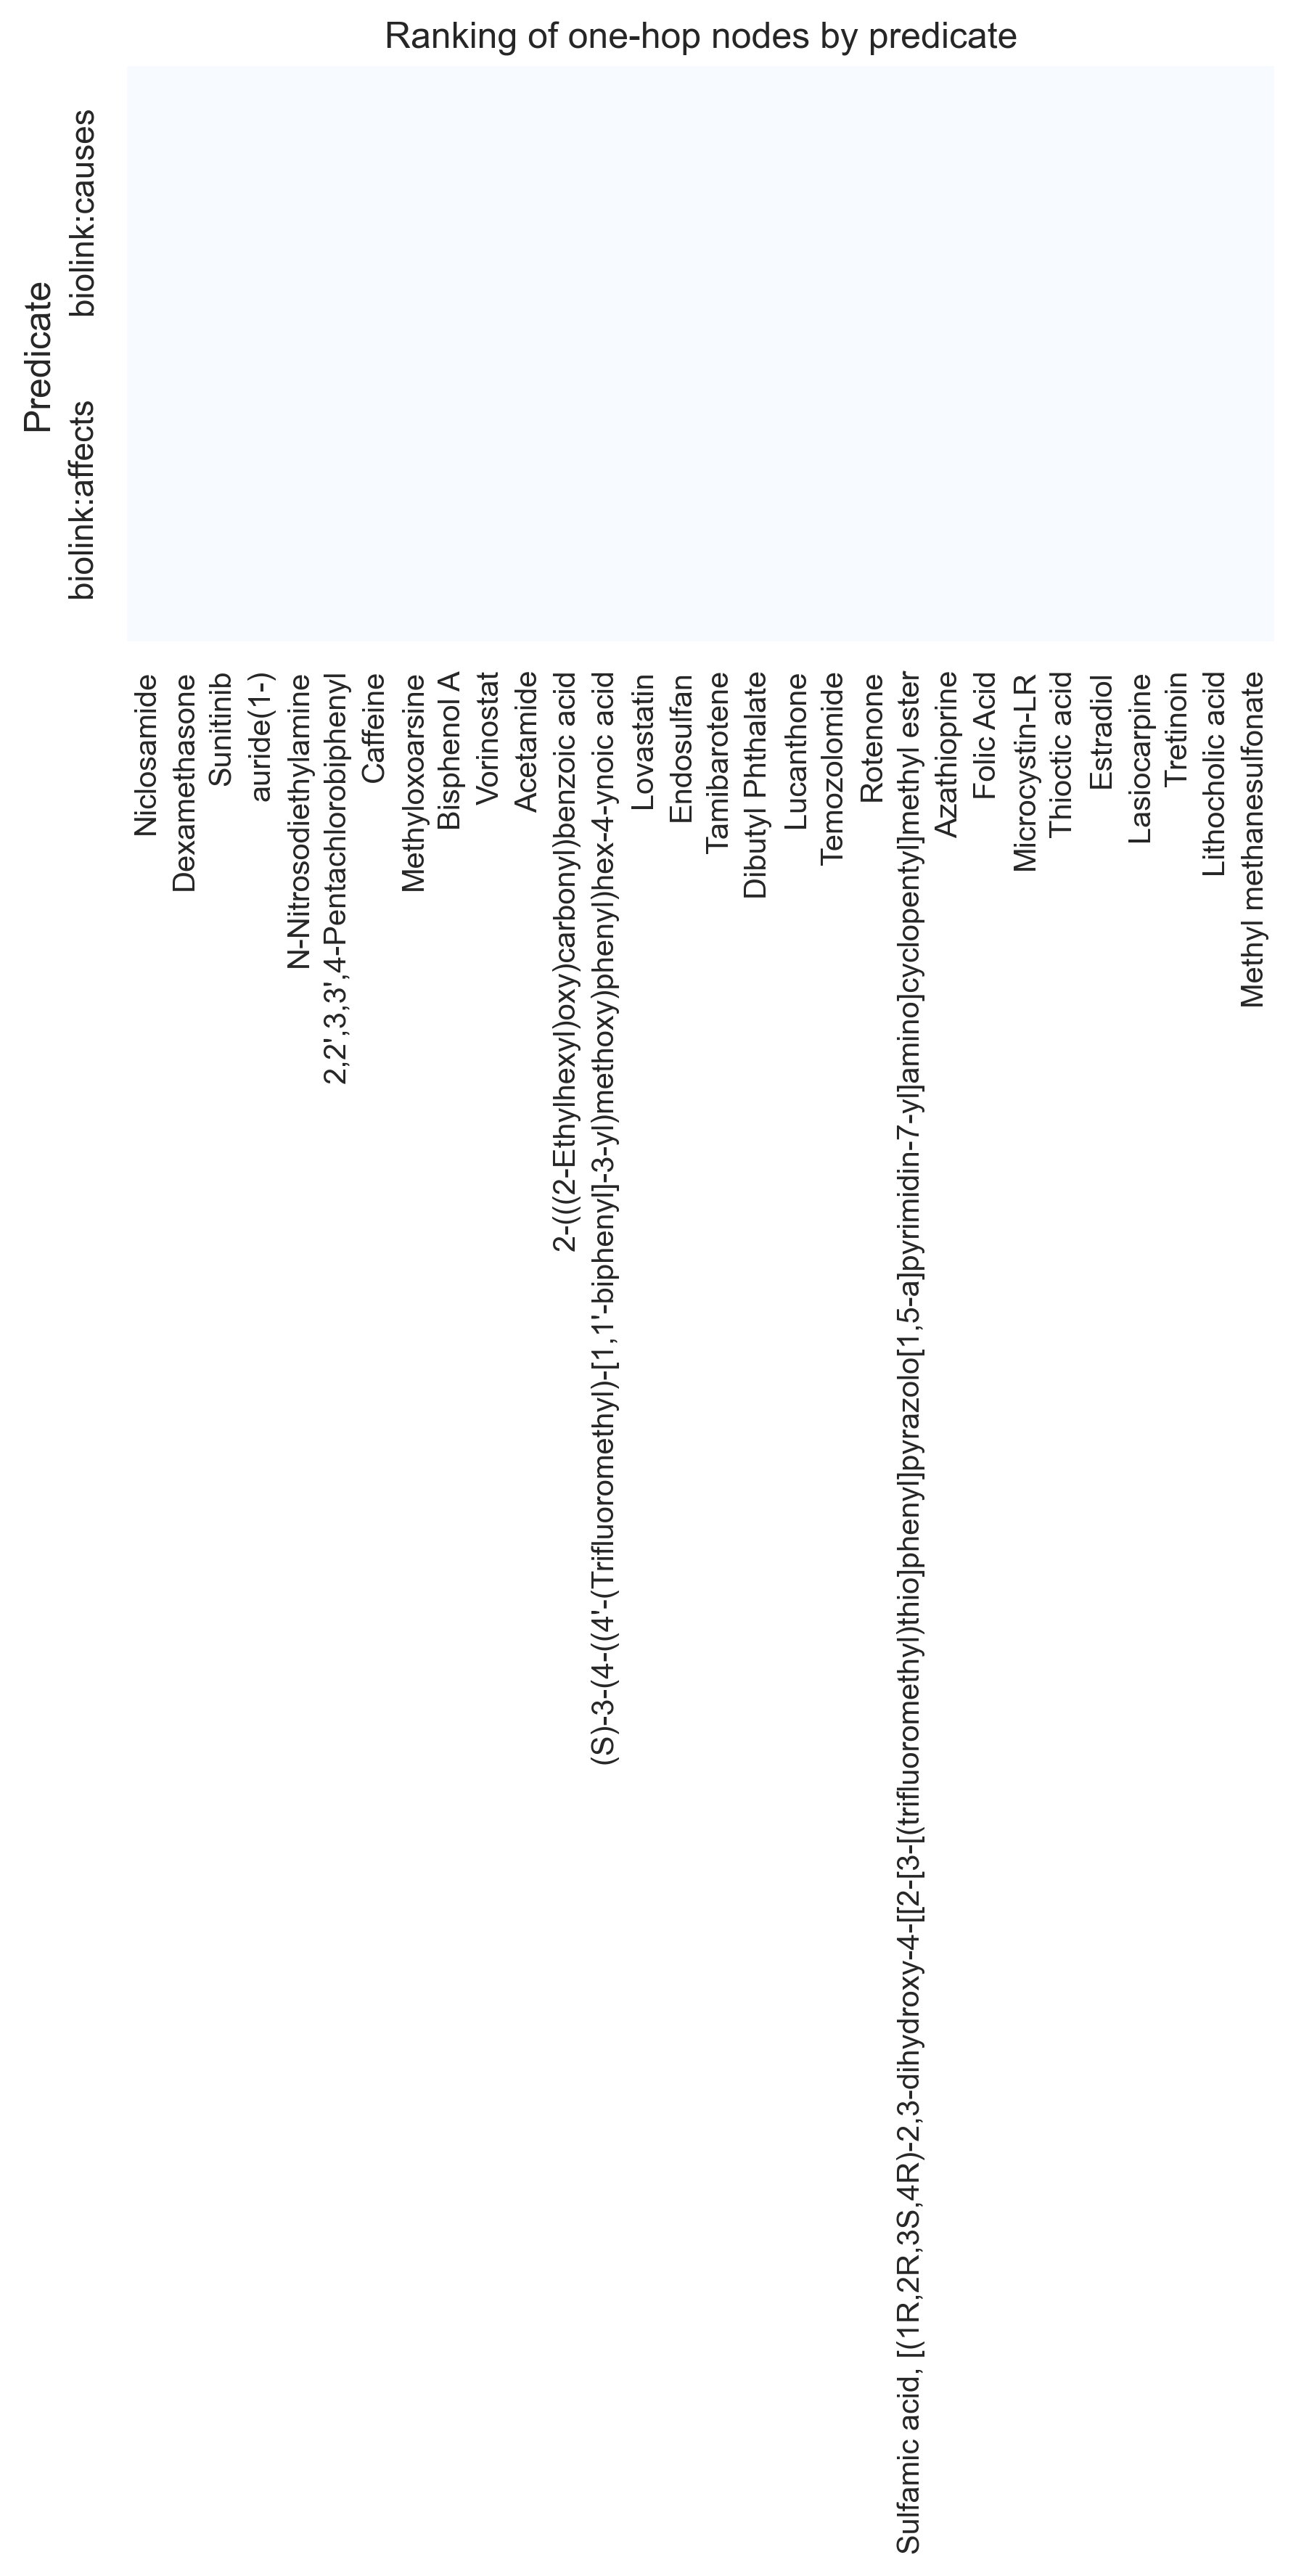

In [38]:
# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, 
                                 result_parsed, 
                                 num_of_nodes = 30, 
                                 input_query = input_node1_id,
                                 fontsize = 10,
                                 title_fontsize=12)

In [24]:
# Step 9: Format query json
query_json2 = TCT.format_query_json(input_node3_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node3_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates_2) # a list of predicates


In [25]:
# Step 10: Query Translator APIs and parse results
result2 = TCT.parallel_api_query(API_URLs_2,query_json=query_json2, max_workers=len(API_URLs_2))

# Step 11: Parse results
result_parsed2 = TCT.parse_KG(result2)

# Step 12: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores2 = TCT.rank_by_primary_infores(result_parsed2, input_node3_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:672"


'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
Warning Code:404:https://api.bte.ncats.io/v1/8f08d1446e0bb9c2b323713ce83e2bd3/query
Warning Code:404:https://api.bte.ncats.io/v1/bde72db681ec0b8f9eeb67bb6b8dd72c/query
'https://automat.ci.renci.org/drugcentral/1.4/query' generated an exception: HTTPSConnectionPool(host='automat.ci.renci.org', port=443): Max retries exceeded with url: /drugcentral/1.4/query (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x14f7b12a0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

PUBCHEM.COMPOUND:10339178:no preferred name
CHEMBL.COMPOUND:CHEMBL502835:no preferred name
MESH:D000069585:no preferred name
MESH:D004921:no preferred name
CHEMBL.COMPOUND:CHEMBL1201583:no preferred name
UMLS:C0042845:no preferred name
DRUGBANK:DB14009:no preferred name
DRUGBANK:DB04539:no preferred name
DRUGBANK:DB04945:no preferred name
MESH:C416023:no preferred name
MESH:C034483:no preferred name
DRUGBANK:DB06448:no preferred name
MESH:D004967:no preferred name
MESH:D001194:no preferred name
MESH:D000477:no preferred name
MESH:C099555:no preferred name
MESH:D019161:no preferred name
CHEMBL.COMPOUND:CHEMBL3989514:no preferred name
PUBCHEM.COMPOUND:60505:no preferred name
MESH:C455861:no preferred name
MESH:D008942:no preferred name
MESH:D000080045:no preferred name
DRUGBANK:DB01388:no preferred name
DRUGBANK:DB11639:no preferred name
CHEMBL.COMPOUND:CHEMBL59030:no preferred name
DRUGBANK:DB16187:no preferred name
UNII:1LXW6D3W2Z:no preferred name
DRUGBANK:DB00260:no preferred name
DR

<AxesSubplot:title={'center':'Ranking of one-hop nodes by predicate'}, ylabel='Predicate'>

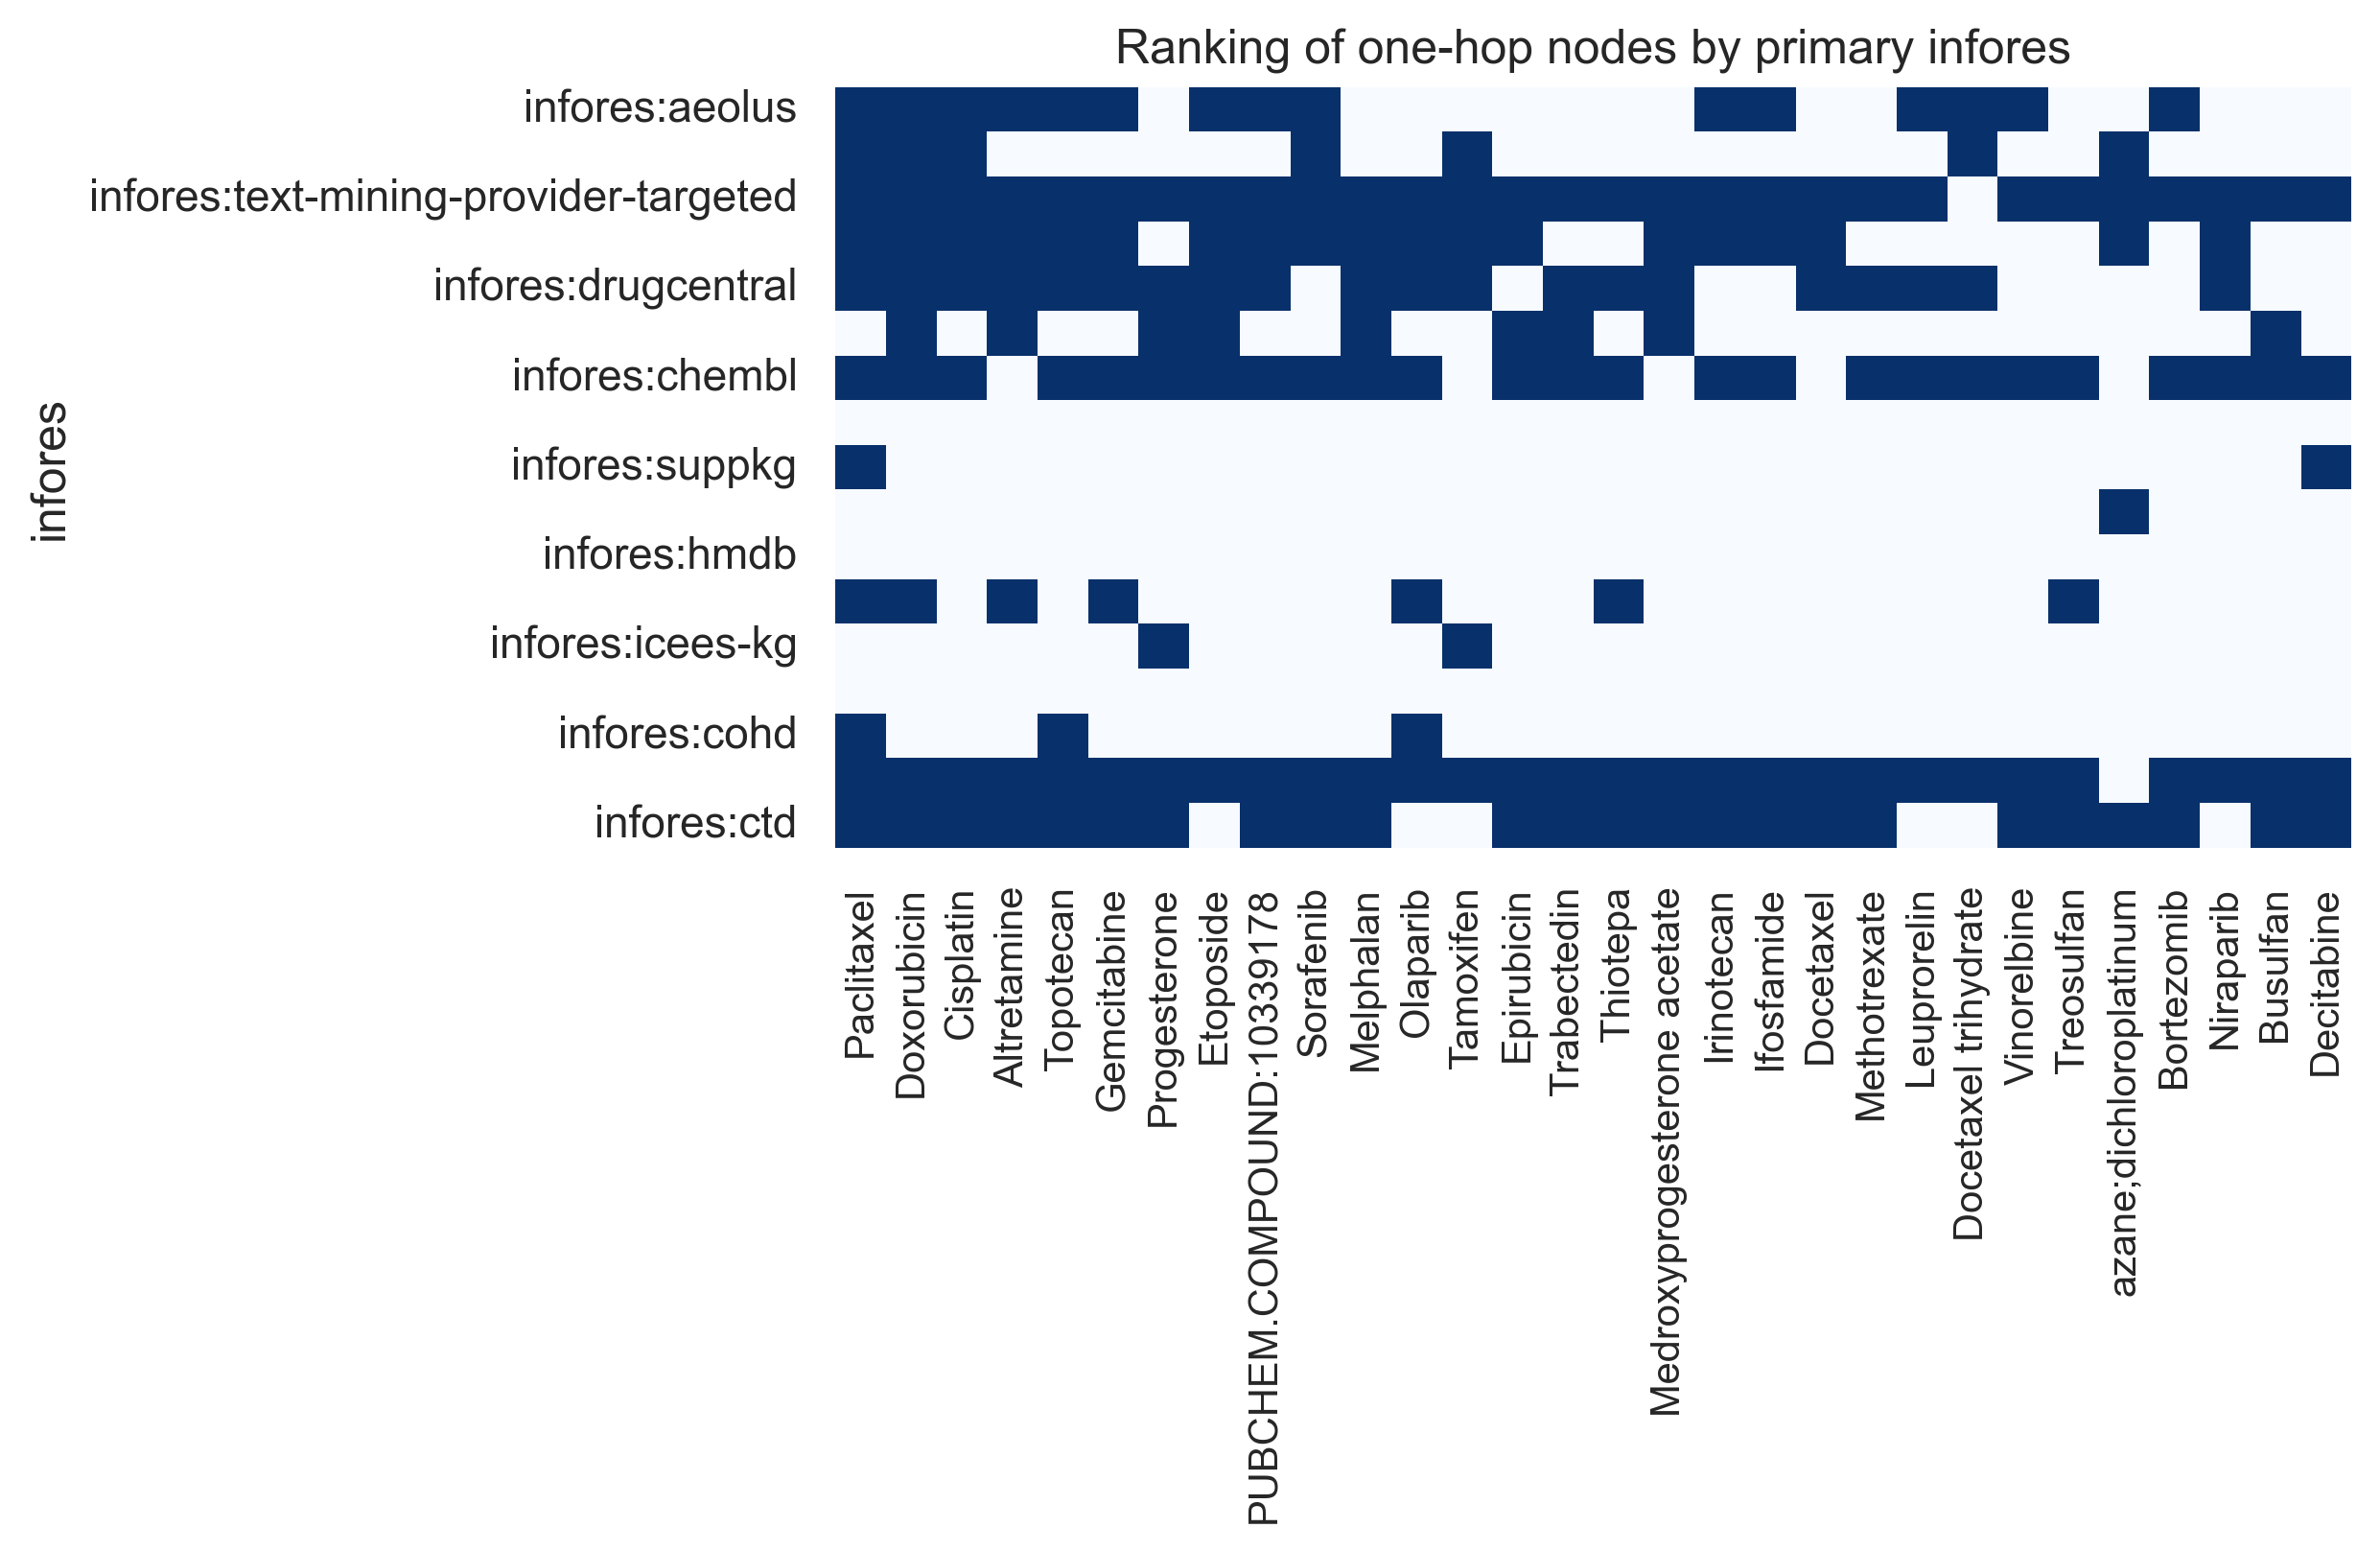

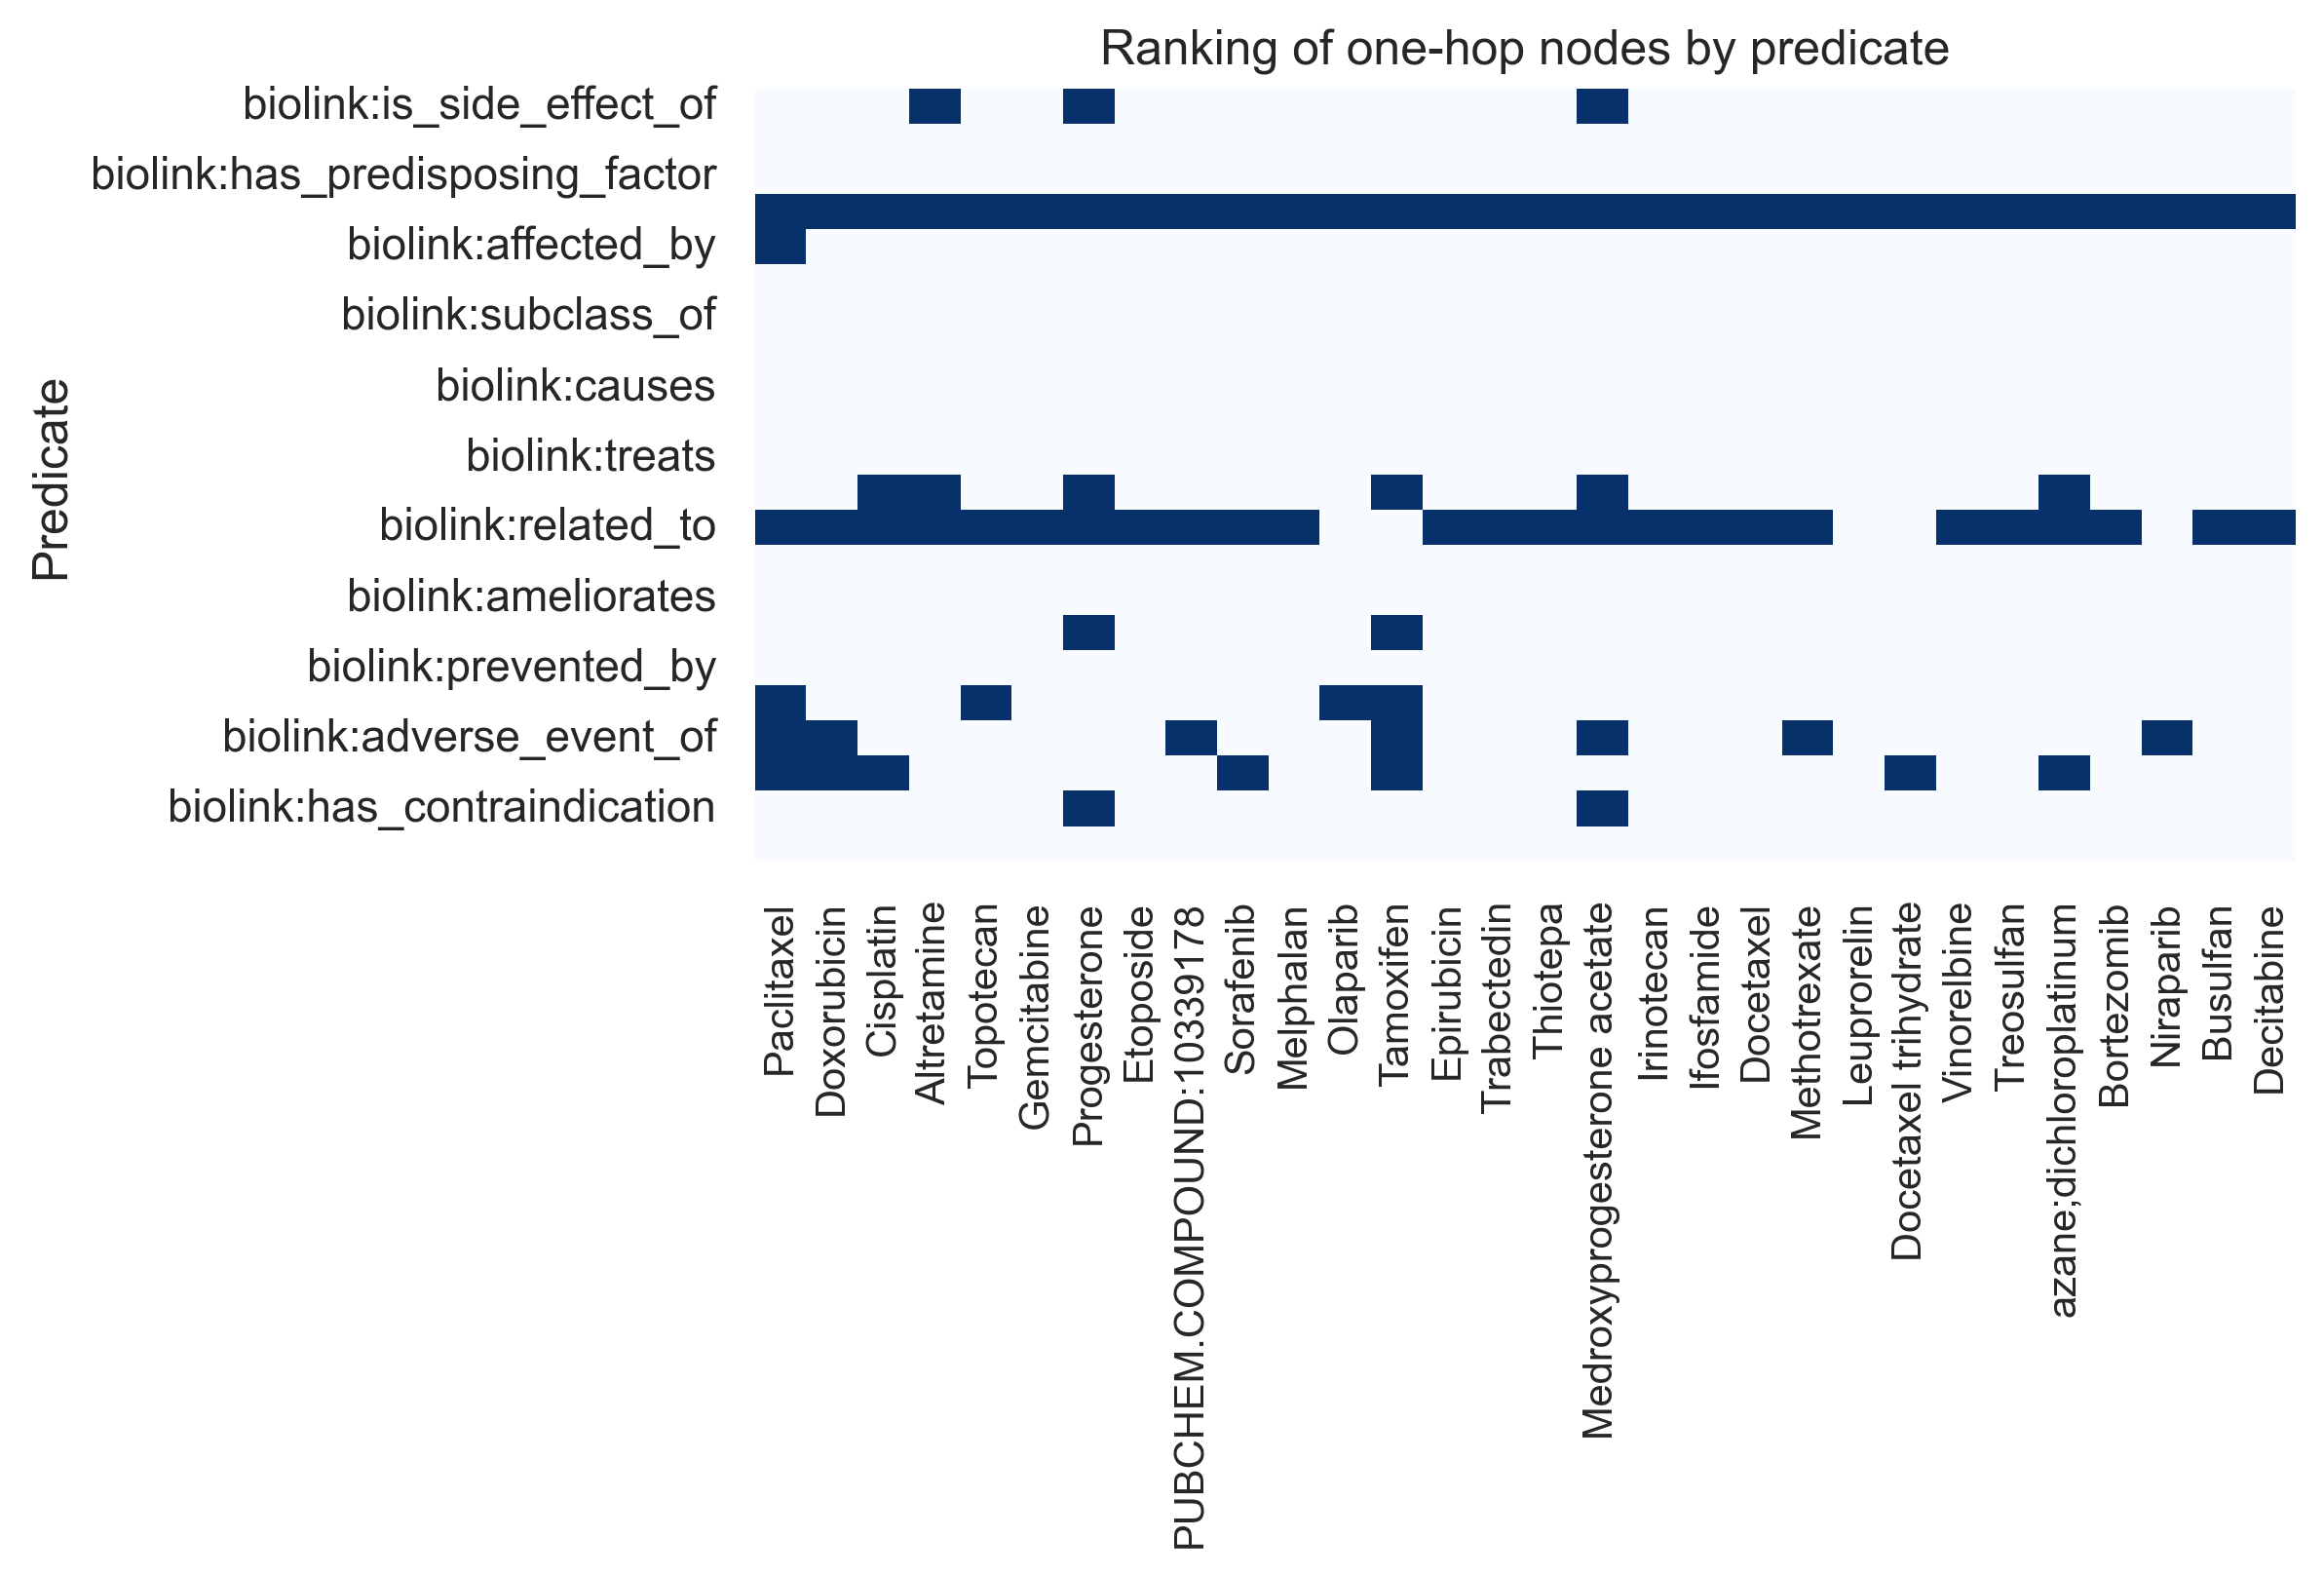

In [26]:
# Step 13: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores2, result_parsed2, num_of_nodes = 30, 
                                 input_query = input_node3_id,
                                 fontsize = 10,
                                 title_fontsize=12)

In [27]:
possible_paths = len(set(result_ranked_by_primary_infores['output_node']).intersection(set(result_ranked_by_primary_infores2['output_node'])))
print("Number of possible paths: ", possible_paths)


Number of possible paths:  242


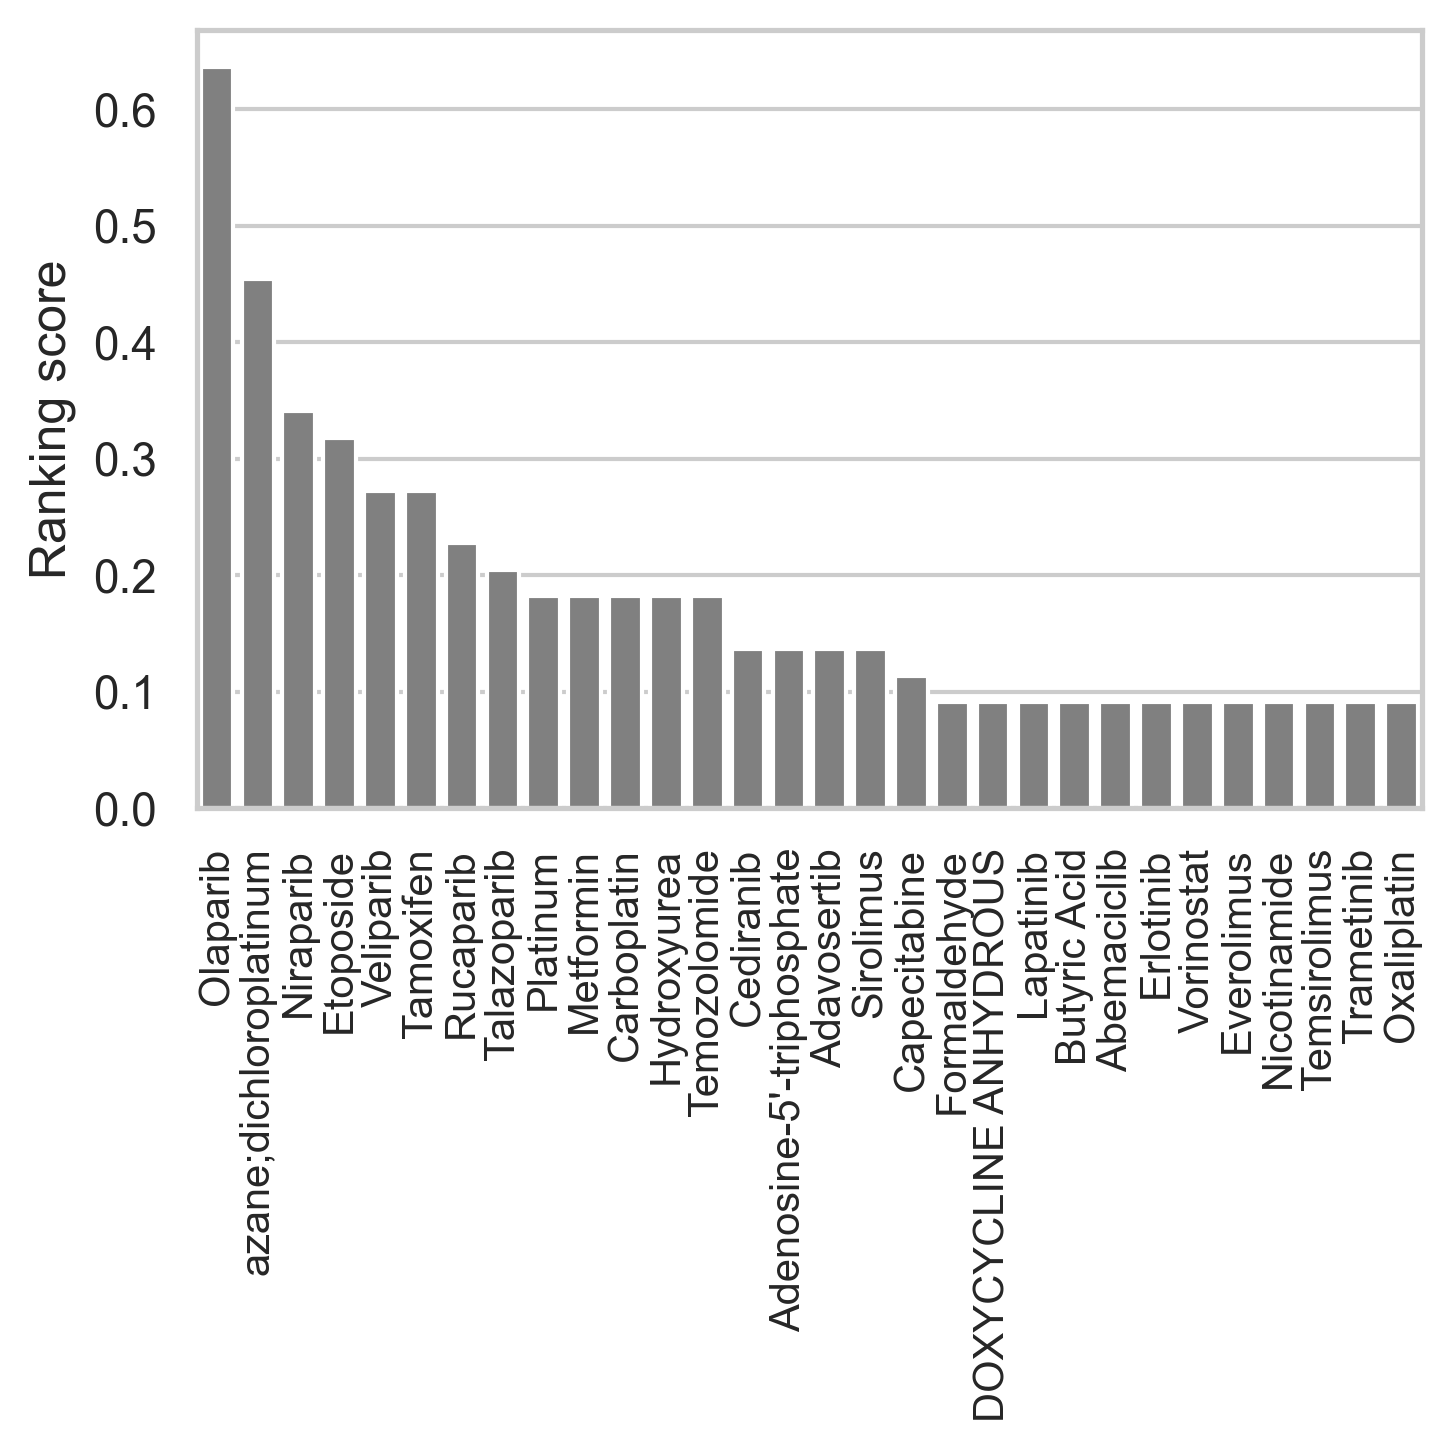

,score
Olaparib,0.636364
azane;dichloroplatinum,0.454545
Niraparib,0.340909
Etoposide,0.318182
Veliparib,0.272727
...,...
[OBSOLETE] sodium citrate,0.022727
Chlorambucil,0.022727
Honokiol,0.022727
Marizomib,0.022727


In [28]:
TCT.merge_ranking_by_number_of_infores(result_ranked_by_primary_infores, result_ranked_by_primary_infores2, 
                                       top_n = 30,
                                       fontsize=10,
                                       title_fontsize=12,)

/Users/guangrong/Documents/GitHub_project/Translator_component_toolkit/notebooks/../src/TCT.py:876: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  ax.set_ylabel("Ranking score")


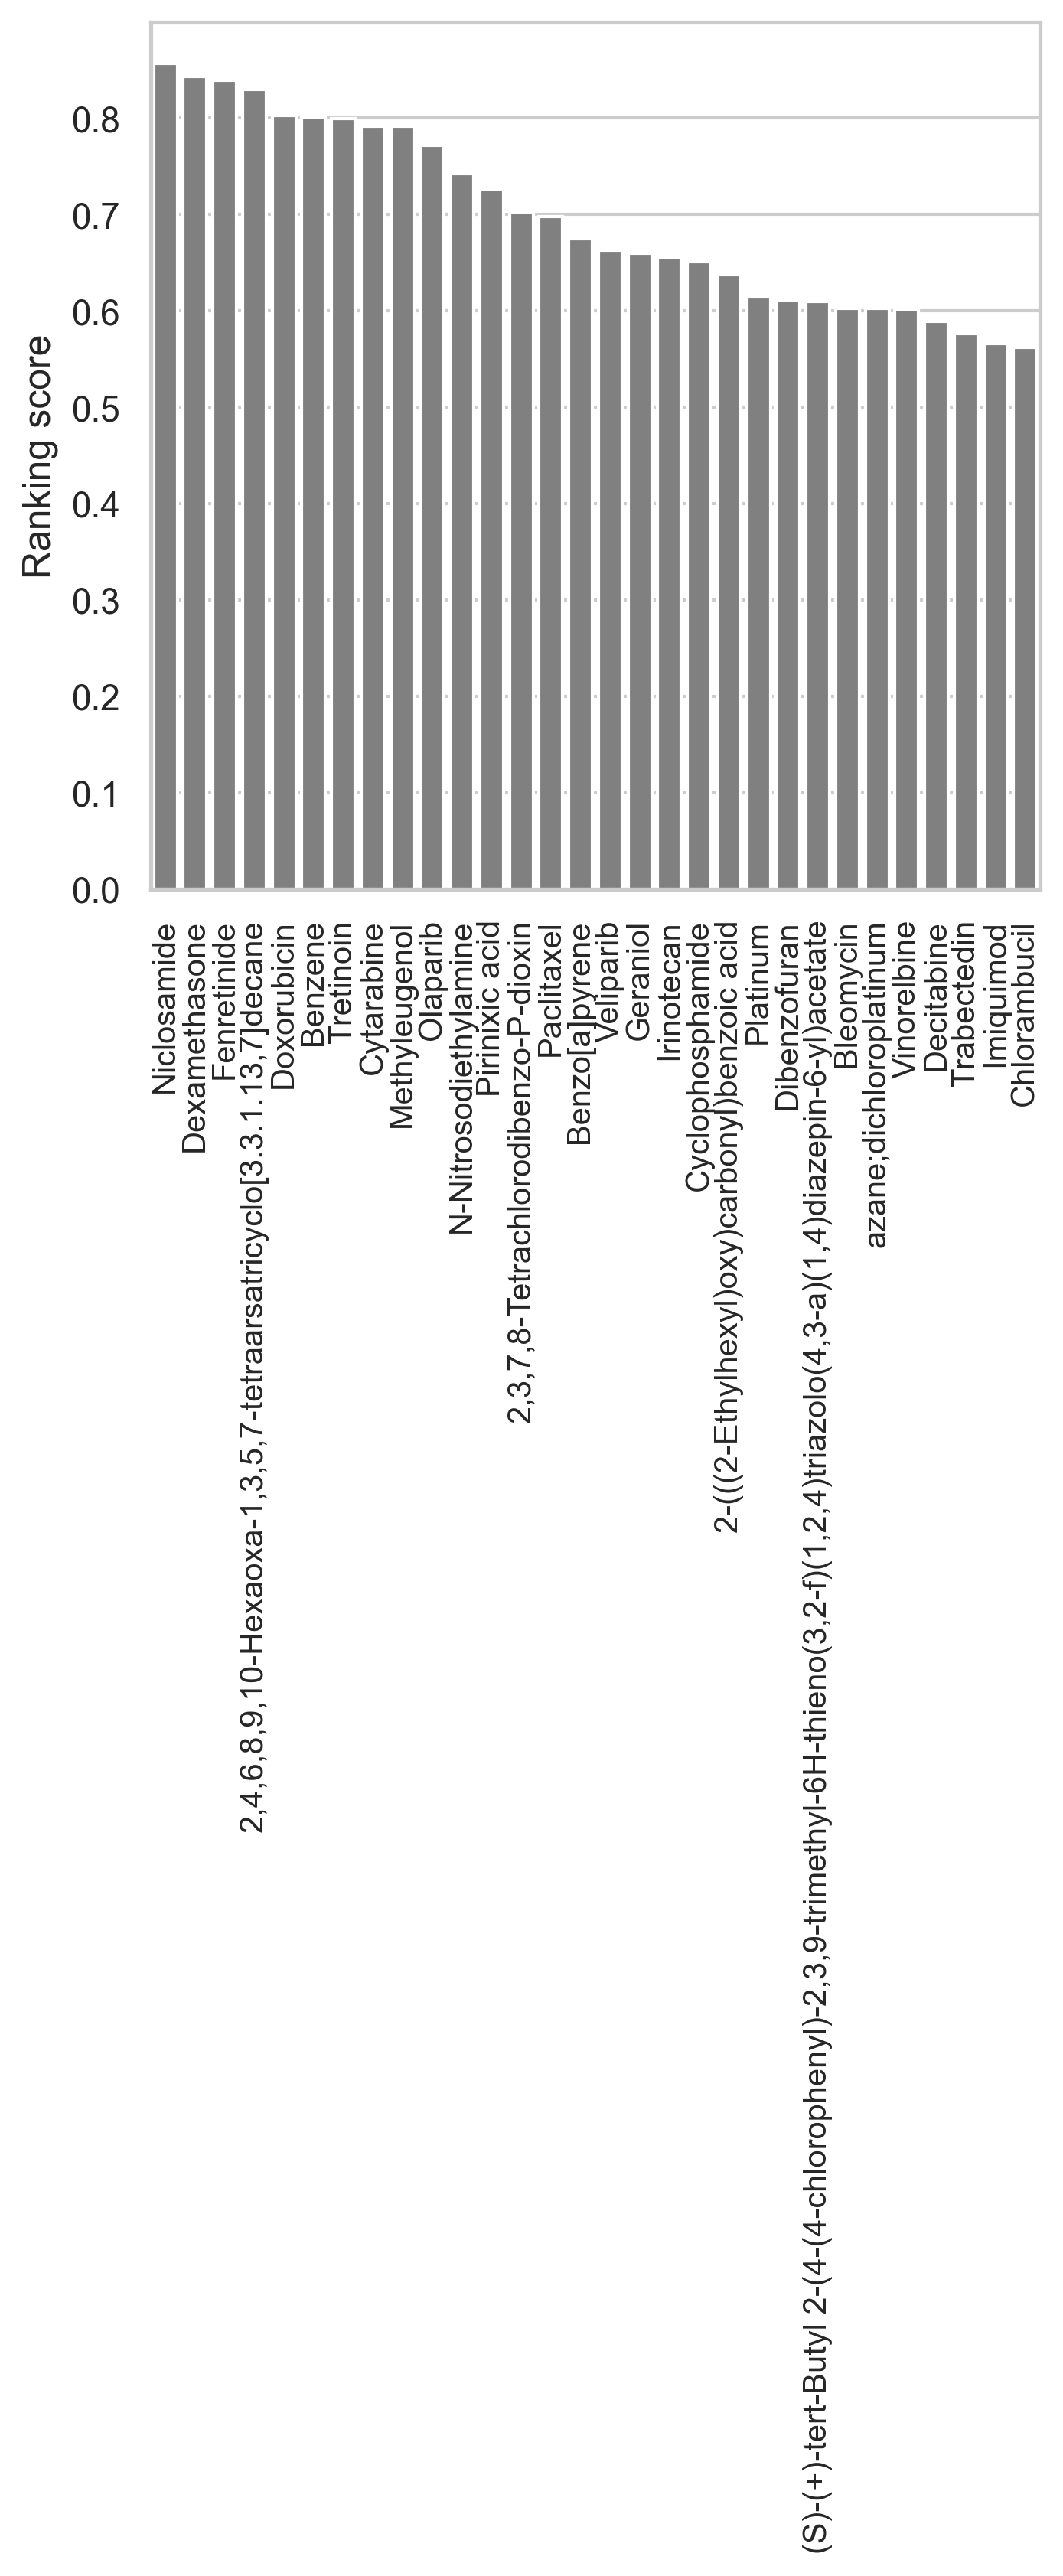

,output_node,score
Niclosamide,PUBCHEM.COMPOUND:4477,0.856691
Dexamethasone,PUBCHEM.COMPOUND:5743,0.843099
Fenretinide,PUBCHEM.COMPOUND:5288209,0.839333
"2,4,6,8,9,10-Hexaoxa-1,3,5,7-tetraarsatricyclo[3.3.1.13,7]decane",PUBCHEM.COMPOUND:518605,0.829737
Doxorubicin,PUBCHEM.COMPOUND:31703,0.802675
...,...,...
"3H-Pyridazino[3,4,5-de]quinazolin-3-one, 8-[(1,3-dihydro-2H-isoindol-2-yl)methyl]-1,2-dihydro-",PUBCHEM.COMPOUND:135565981,0.007930
Iniparib,PUBCHEM.COMPOUND:9796068,0.007891
Proline,PUBCHEM.COMPOUND:145742,0.000997
Deoxyribonucleic acid,PUBCHEM.COMPOUND:44135672,0.000703


In [29]:
TCT.merge_by_ranking_index(result_ranked_by_primary_infores,
                           result_ranked_by_primary_infores2, 
                           top_n=30, fontsize=10, 
                           title_fontsize=12)

In [31]:
def visulize_path(input_node1_id, intermediate_node, input_node3_id, result, result2):
    forplot_subject = []
    forplot_object = []
    forplot_predicate = []
    forplot_Infores = []

    for k in result.keys():
        if (result[k]['object'] == intermediate_node and result[k]['subject'] == input_node1_id) or (result[k]['subject'] == intermediate_node and result[k]['object'] == input_node1_id)  :
            forplot_subject.append(result[k]['subject'])
            forplot_object.append(result[k]['object'])
            #forplot_predicate.append(result[k]['predicate'].split(':')[1])
            cur_sources_list = []
            sources = result[k]['sources']
            
            for s in sources:
                cur_source = s['resource_id']
                cur_sources_list.append(cur_source)
                
            forplot_Infores.append(cur_sources_list)

            forplot_predicate.append(result[k]['predicate'].split(':')[1] + "::" + ';'.join(cur_sources_list))

    for k in result2.keys():
        if (result2[k]['object'] == intermediate_node and result2[k]['subject'] ==input_node3_id ) or (result2[k]['subject'] == intermediate_node and result2[k]['object'] ==input_node3_id)  :
            forplot_subject.append(result2[k]['subject'])
            forplot_object.append(result2[k]['object'])
            #forplot_predicate.append(result2[k]['predicate'].split(':')[1])
            cur_sources_list = []
            sources = result2[k]['sources']
            
            for s in sources:
                cur_source = s['resource_id']
                cur_sources_list.append(cur_source)
                
            forplot_Infores.append(cur_sources_list)
            forplot_predicate.append(result2[k]['predicate'].split(':')[1] + "::" +  ';'.join(cur_sources_list))
            
    forplot =  pd.DataFrame({"Subject":forplot_subject, "Object":forplot_object, "Predicates":forplot_predicate})

    # get preferred name
    subject_name = list(forplot["Subject"] )
    object_name = list(forplot["Object"])
    dic_id_map = TCT.ID_convert_to_preferred_name_nodeNormalizer(subject_name+ object_name)
    new_subject_name = []
    for item in subject_name:
        if item in dic_id_map:
            new_subject_name.append(dic_id_map[item])
        else:
            new_subject_name.append(item)   

    new_object_name = []
    for item in object_name:
        if item in dic_id_map:
            new_object_name.append(dic_id_map[item])
        else:
            new_object_name.append(item)         
    forplot['Subject_name'] = new_subject_name
    forplot['Object_name'] = new_object_name

    forplot = forplot.drop_duplicates()

    import networkx as nx
    import matplotlib.pyplot as plt
    import ipycytoscape

    graph = nx.from_pandas_edgelist(forplot, source='Subject_name', target='Object_name', edge_attr=[ 'Predicates'], create_using=nx.MultiGraph)
    graph_style = [{'selector': 'node[id]',
                             'style': {
                                  'font-family': 'Arial',
                                  'font-size': '12px',
                                 'text-valign': 'center',
                                 'label': 'data(id)',
                        }},
                        {'selector': 'node',
                         'style': {
                             'background-color': 'lightblue',
                             'shape': 'round-rectangle',
                             'width': '3em',
                         }},
                        {'selector': 'edge[Predicates]',
                         'style': {
                             'label': 'data(Predicates)',
                             'font-size': '8px',
                         }},
                        {"selector": "edge.directed",
                         "style": {
                            "curve-style": "bezier",
                            "target-arrow-shape": "triangle",
                        }},
                       {"selector": "edge",
                         "style": {
                            "curve-style": "bezier",
                        }},

                    ]
    pathgraph = ipycytoscape.CytoscapeWidget()
    pathgraph.graph.add_graph_from_networkx(graph)
    pathgraph.set_layout(title='Path', nodeSpacing=80, edgeLengthVal=50, )
    pathgraph.set_style(graph_style)

    display(pathgraph)
    return(forplot)


In [32]:
visulize_path(input_node1_id, TCT.get_curie("Ethanol"), input_node3_id, result, result2)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'Path', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cy…

,Subject,Object,Predicates,Subject_name,Object_name
0,PUBCHEM.COMPOUND:702,NCBIGene:675,affects::infores:ctd;infores:automat-cam-kp,Ethanol,BRCA2
1,PUBCHEM.COMPOUND:702,NCBIGene:675,causes::infores:ctd;infores:automat-cam-kp,Ethanol,BRCA2
2,NCBIGene:675,PUBCHEM.COMPOUND:702,affected_by::infores:ctd;infores:molepro,BRCA2,Ethanol
3,NCBIGene:675,PUBCHEM.COMPOUND:702,occurs_together_in_literature_with::infores:pf...,BRCA2,Ethanol
4,MONDO:0008170,PUBCHEM.COMPOUND:702,contribution_from::infores:text-mining-provide...,ovarian cancer,Ethanol
5,MONDO:0008170,PUBCHEM.COMPOUND:702,treated_by::infores:text-mining-provider-targe...,ovarian cancer,Ethanol
6,MONDO:0008170,PUBCHEM.COMPOUND:702,contribution_from::infores:biothings-explorer,ovarian cancer,Ethanol
7,MONDO:0008170,PUBCHEM.COMPOUND:702,treated_by::infores:text-mining-provider-targe...,ovarian cancer,Ethanol
8,MONDO:0008170,PUBCHEM.COMPOUND:702,contribution_from::infores:text-mining-provide...,ovarian cancer,Ethanol
